In [1]:
import collections
# Prepare paths to local utilities
import os
import sys

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import torch.nn
import sklearn
from sklearn.metrics import mean_squared_error

In [2]:
is_kaggle = (os.environ.get("PWD", "") == "/kaggle/working")
print(f"Are we running in Kaggle? {is_kaggle}")

Are we running in Kaggle? False


In [3]:
if not is_kaggle:
    models_path = os.path.abspath(os.path.join('..', 'model'))
    utils_path = os.path.abspath(os.path.join('..', 'util'))
    sys.path.append(models_path)
    sys.path.append(utils_path)

    %load_ext autoreload
    %autoreload 2

    from download.DataDownloader import DataDownloader
    from collect.DataframeCollector import DataframeCollector
    from collect.TestSetSplitter import TestSetSplitter
    from collect.DatasetPreparation import DatasetPreparation
    from processing.DataPreprocessor import DataPreprocessor
    from reservoir.BasicESNCuda import BasicESNCuda as BasicESN
    from reservoir.ESNUtil import generate_input_weights

else:
    from datadownloader.datadownloader import DataDownloader
    from dataframecollector.dataframecollector import DataframeCollector
    from testsetsplitter.testsetsplitter import TestSetSplitter
    from datasetpreparation.datasetpreparation import DatasetPreparation
    from datapreprocessor.datapreprocessor import DataPreprocessor
    from basicesncuda.basicesncuda import BasicESNCuda as BasicESN
    from esnutil.esnutil import generate_input_weights

In [4]:
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import contextlib


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    '''
    Context manager to patch joblib to report into tqdm progress bar given as argument
    :param tqdm_object: The tqdm progress bar
    '''

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback

    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
data_preparation = DatasetPreparation()

input_features = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
output_features = ['label']

data_preparation.prepare_dataset('har70plus', input_features, output_features)
X_train_scaled, y_train_encoded = data_preparation.get_preprocessed_data('train')
X_val_scaled, y_val_encoded = data_preparation.get_preprocessed_data('val')
X_test_scaled, y_test_encoded = data_preparation.get_preprocessed_data('test')

data_preprocessor = DataPreprocessor()

Dataset already downloaded
Discovered  18  csv files in  E:\PyCharm\COM6906-Dissertation\data\har70plus
Loading the csv files into dataframes
Loaded  18  dataframes
Concatenating the dataframes
Data shape:  [(103860, 9), (131367, 9), (116413, 9), (150758, 9), (87006, 9), (122714, 9), (120125, 9), (130494, 9), (121763, 9), (122061, 9), (128063, 9), (119310, 9), (123599, 9), (101510, 9), (153517, 9), (138278, 9), (147045, 9), (141714, 9)]
Number of frames in training set: 17
Number of frames in validation set: 17
Number of frames in testing set: 18
X_train shape: (1357646, 6), Y_train shape: (1357646,)
X_val shape: (339404, 6), Y_val shape: (339404,)
X_test shape: (562547, 6), Y_test shape: (562547,)
Y_train encoded shape: (1357646, 7)
Y_val encoded shape: (339404, 7)
Y_test encoded shape: (562547, 7)
Y_train decoded shape: (1357646, 1)
Y_val decoded shape: (339404, 1)
Y_test decoded shape: (562547, 1)
X_train scaled shape: (1357646, 6)
X_val scaled shape: (339404, 6)
X_test scaled shape

In [6]:
def train_model(x, y, x_val, y_val, model, optimiser, loss_fn, performance_fn, epochs=100, batch_size=32):
    losses = []
    val_losses = []

    performances = []
    val_performances = []

    running_loss = 0.0
    iter_count = 0
    
    x = torch.tensor(x, dtype=torch.float32, device='cuda')
    y = torch.tensor(y, dtype=torch.float32, device='cuda')
    X_val = torch.tensor(x_val, dtype=torch.float32, device='cuda')
    y_val = torch.tensor(y_val, dtype=torch.float32, device='cuda')
    y_val = torch.argmax(y_val, dim=1)
    
    # x data is in the shape of (sequence_length, n_features)
    # y data is in the shape of (sequence_length, n_classes) in one-hot encoded format

    with torch.device('cuda'):
        for epoch in range(epochs):
            for i in range(0, len(x), batch_size):
                # The last batch may not be a full batch so we need to check
                if i + batch_size > len(x):
                    X_batch = x[i:]
                    y_batch = y[i:]
                else:
                    X_batch = x[i:i + batch_size]
                    y_batch = y[i:i + batch_size]
    
                optimiser.zero_grad()
    
                # Forward pass
                outputs = model(X_batch)
                
                # The shape of outputs is (sequence_length, n_classes)
                # The shape of y_batch is (sequence_length, n_classes) in one-hot encoded format
                # We need to convert y_batch to a single column tensor
                y_batch = torch.argmax(y_batch, dim=1)
                
                # Calculate loss
                loss = loss_fn(outputs, y_batch)
                losses.append(loss.item())
    
                # Backward pass
                loss.backward()
    
                # Update the weights
                optimiser.step()
    
                with torch.no_grad():
                    performance = performance_fn(outputs.cpu(), y_batch.cpu())
                    performances.append(performance)
    
                running_loss += loss.item()
                iter_count += 1
    
            # After each epoch, calculate the validation loss
            with torch.no_grad():
                
                # The shape of x_val is (sequence_length, n_features)
                # The shape of y_val is (sequence_length, n_classes) in one-hot encoded format
                # We need to convert y_val to a single column tensor
    
                val_outputs = model(X_val)
                
                val_loss = loss_fn(val_outputs, y_val)
                val_losses.append(val_loss.item())
    
                val_performance = performance_fn(val_outputs.cpu(), y_val.cpu())
                val_performances.append(val_performance)
    
                print(f"Epoch {epoch + 1}, Loss: {running_loss / iter_count}, Val Loss: {val_loss.item()}")
    
                running_loss = 0.0
                iter_count = 0
    
    return losses, val_losses, performances, val_performances


In [10]:
import torch.nn


# Let's define a basic RNN model as part of the baseline
class RnnBaseline(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(RnnBaseline, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.RNNCell(input_size=input_size, hidden_size=128, device='cuda'),

            # Output layer
            torch.nn.Linear(128, output_size, device='cuda'),
            
            # ReLU activation
            torch.nn.ReLU(),
            
            # Softmax layer
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

In [11]:
# Let's train the model
model = RnnBaseline(6, 7).cuda()

weights_tensor = torch.tensor(data_preparation.get_class_weights(), dtype=torch.float32, device='cuda')

optimiser = torch.optim.Adamax(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)

# For the performance function, we will use ROC AUC
from sklearn.metrics import f1_score


def performance_fn(outputs, y):
    # The prediction data is in a one-hot encoded format
    _, predicted = torch.max(outputs.data, 1)
    return f1_score(y, predicted, average='weighted')


losses, val_losses, performances, val_performances = train_model(X_train_scaled, y_train_encoded, X_val_scaled,
                                                                 y_val_encoded, model, optimiser, loss_fn,
                                                                 performance_fn, epochs=100, batch_size=100)

Epoch 1, Loss: 1.6033448648793431, Val Loss: 1.6651630401611328
Epoch 2, Loss: 1.5299583986492653, Val Loss: 1.6580830812454224
Epoch 3, Loss: 1.5256544188353136, Val Loss: 1.6550030708312988
Epoch 4, Loss: 1.5229064828211423, Val Loss: 1.651903748512268
Epoch 5, Loss: 1.521467828483691, Val Loss: 1.6497961282730103
Epoch 6, Loss: 1.5205403954885999, Val Loss: 1.648806095123291
Epoch 7, Loss: 1.519498091291203, Val Loss: 1.6482163667678833
Epoch 8, Loss: 1.5194054721442574, Val Loss: 1.6476041078567505
Epoch 9, Loss: 1.519178766753683, Val Loss: 1.6475571393966675
Epoch 10, Loss: 1.519305206200349, Val Loss: 1.6472814083099365
Epoch 11, Loss: 1.519146505789087, Val Loss: 1.6469701528549194
Epoch 12, Loss: 1.5189857812959298, Val Loss: 1.6467715501785278
Epoch 13, Loss: 1.5189349641063792, Val Loss: 1.646482229232788
Epoch 14, Loss: 1.5188453169206881, Val Loss: 1.6461588144302368
Epoch 15, Loss: 1.5187727382013265, Val Loss: 1.6458871364593506
Epoch 16, Loss: 1.518767864686396, Val Los

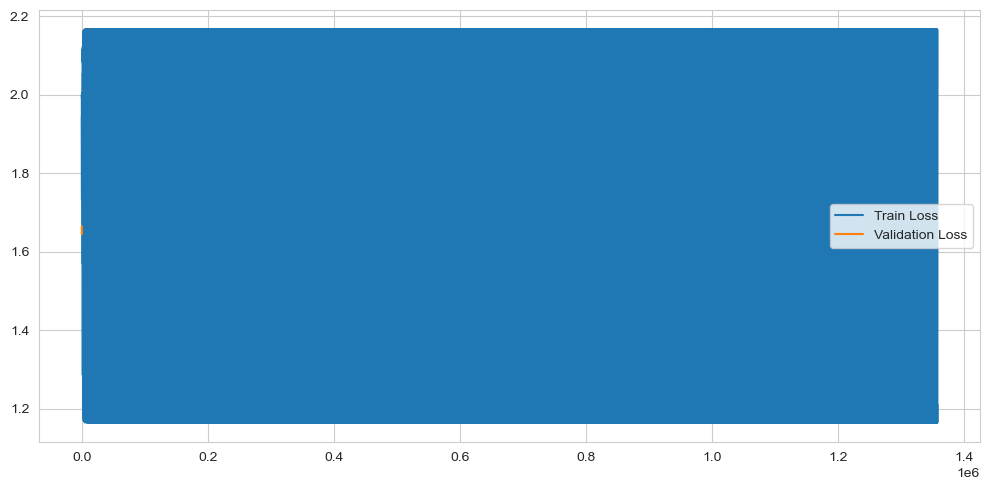

In [12]:
# Let's plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

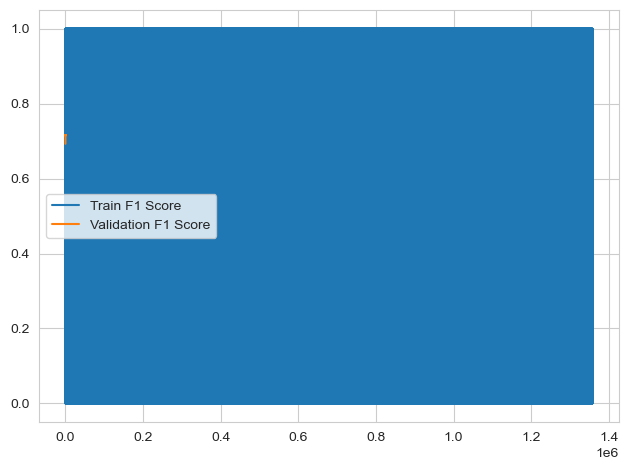

In [13]:
# Let's plot the performances
plt.plot(performances, label='Train F1 Score')
plt.plot(val_performances, label='Validation F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Let's evaluate the model on the test set
X_test = torch.tensor(X_test_scaled, dtype=torch.float32, device='cuda')
y_test = torch.tensor(y_test_encoded, dtype=torch.float32, device='cuda')

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss_fn(test_outputs, torch.argmax(y_test, dim=1))
    test_performance = performance_fn(test_outputs.cpu(), torch.argmax(y_test, dim=1).cpu())
    
    print(f"Test Loss: {test_loss.item()}, Test F1 Score: {test_performance}")

Test Loss: 1.9358501434326172, Test F1 Score: 0.5610301840904128


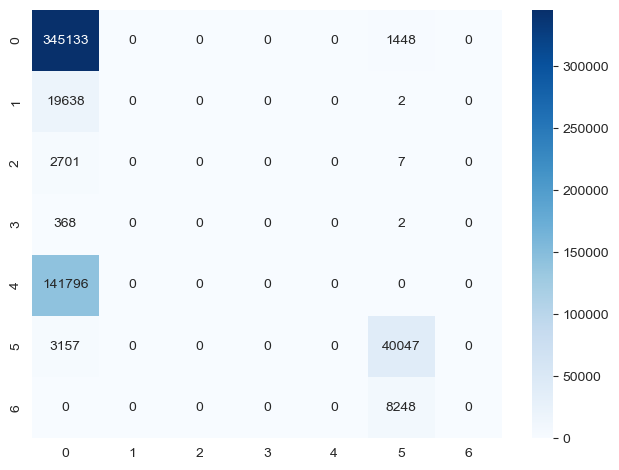

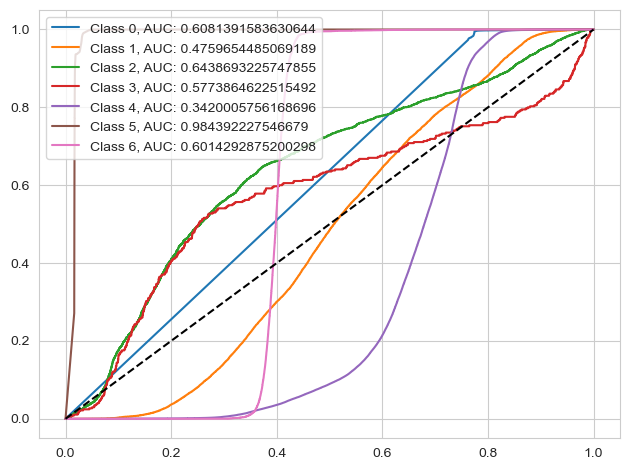

In [15]:
# Let's plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

with torch.no_grad():
    _, predicted = torch.max(test_outputs.data, 1)
    cm = confusion_matrix(torch.argmax(y_test, dim=1).cpu().numpy(), predicted.cpu().numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.tight_layout()
    plt.show()
    
    # Let's plot the ROC curve
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score
    
    y_test = torch.argmax(y_test, dim=1).cpu().numpy()
    y_score = test_outputs.cpu().numpy()
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=list(range(7)))[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    for i in range(7):
        plt.plot(fpr[i], tpr[i], label=f'Class {i}, AUC: {roc_auc_score(label_binarize(y_test, classes=list(range(7)))[:, i], y_score[:, i])}')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    
    plt.tight_layout()
    
    plt.show()

In [16]:
# Print the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted.cpu().numpy()))


C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80    346581
           1       0.00      0.00      0.00     19640
           2       0.00      0.00      0.00      2708
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00    141796
           5       0.80      0.93      0.86     43204
           6       0.00      0.00      0.00      8248

    accuracy                           0.68    562547
   macro avg       0.21      0.27      0.24    562547
weighted avg       0.48      0.68      0.56    562547



C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mail\anaconda3\envs\training\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Save the model
torch.save(model.state_dict(), 'rnn_baseline.pth')
